In this notebook the new data set for leaf area index (LAI) has been compared to the default LAI data set based on the MODIS sattelite informtion. Missing LAI from SPOT are filled with MODIS. 

Furthemore, land use category for the Black Sea in CORINE is categorized as sea (only part fit in the available CORINE data), while in MODIS with lakes it is a lake. The final output file is fixed so the complete Black sea is set to the lake or sea category.

In [1]:
# Loading packages
import xarray as xr 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import urllib
import os
import ssl
import certifi
from urllib.request import urlopen

In [2]:
# Input:
file_spot ="./geo_em.d01_EUR-11_SPOT.nc" 
file_modis="./geo_em.d01_EUR-11_MODIS.nc" 
file_modis_lakes="./geo_em.d01_EUR-11_MODIS_lakes.nc"

# Output
file_lai_updated="./geo_em.d01_EUR-11_newLAI.nc"
file_final2lake ="./geo_em.d01_EUR-11_newLAI_BlackSea2lake.nc"
file_final2sea  ="./geo_em.d01_EUR-11_newLAI_BlackSea2sea.nc"

Download links:<br/>
    file_spot:        https://meteo.unican.es/work/WRF4CORDEX_geogrid_files/geo_em.d01_EUR-11_SPOT.nc <br/>
    file_modis:       https://meteo.unican.es/work/WRF4CORDEX_geogrid_files/geo_em.d01_EUR-11_MODIS.nc <br/> 
    file_modis_lakes: https://meteo.unican.es/work/WRF4CORDEX_geogrid_files/geo_em.d01_EUR-11_MODIS_lakes.nc <br/> 
    file_lai_updated:  https://meteo.unican.es/work/WRF4CORDEX_geogrid_files/geo_em.d01_EUR-11_newLAI.nc <br/> 
    file_final2lake:  https://meteo.unican.es/work/WRF4CORDEX_geogrid_files/geo_em.d01_EUR-11_new_BlackSea2lake.nc <br/>
    file_final2lake:  https://meteo.unican.es/work/WRF4CORDEX_geogrid_files/geo_em.d01_EUR-11_new_BlackSea2sea.nc

# Update LAI SPOT - filling gaps  in winter months with MODIS data

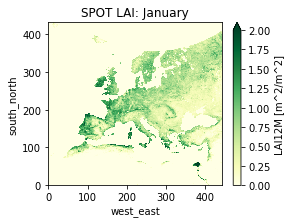

In [3]:
# Loading SPOT LAI and plotting for monthly mean values for January
ds_spot = xr.open_dataset(f'{file_spot}')
lai_spot = ds_spot['LAI12M'][:]
lai_spot[0,0,:,:].where(lai_spot[0,0,:,:] != 255.).plot(cmap='YlGn',vmin=0, vmax=2, aspect=1.3, size=3)
plt.title("SPOT LAI: January")
plt.show()

Note that nothen part of the domain is having missing values. This happens in Januray and December, and this is due to the position of the SPOT sattelite that was not coverine the far north during January and December.

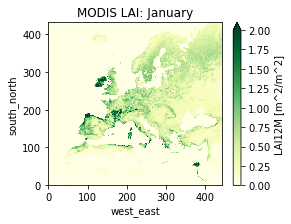

In [4]:
# Loading MODIS LAI and plotting for monthly mean values for January
ds_modis = xr.open_dataset(f'{file_modis}')
lai_modis = ds_modis['LAI12M'][:]
lai_modis[0,0,:,:].where(lai_modis[0,0,:,:] != 255.).plot(cmap='YlGn',vmin=0, vmax=2, aspect=1.3, size=3)
plt.title("MODIS LAI: January")
plt.show()

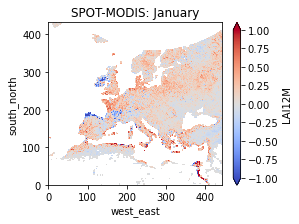

In [5]:
# Plotting an example difference between SPOT and MODIS LAI for January
diff=lai_spot[0,0,:,:].where(lai_spot[0,0,:,:] != 0.) - lai_modis[0,0,:,:].where(lai_modis[0,0,:,:] != 0.)
diff.plot(cmap='coolwarm', vmin=-1, vmax=1, aspect=1.3, size=3)
plt.title("SPOT-MODIS: January")
plt.show()

In [6]:
# Filling the gaps in SPOT LAI data with existing data in MODIS
ds_spot['LAI12M'].data[np.where(ds_spot['LAI12M'].data==0.)] = ds_modis['LAI12M'].data[ds_spot['LAI12M'].data==0.]

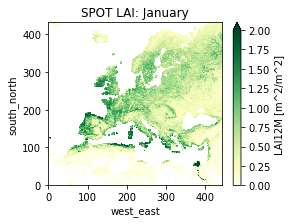

In [7]:
# Plotting the SPOT LAI with gaps filled with MODIS LAI for January
lai_spot = ds_spot['LAI12M'][:]
lai_spot[0,0,:,:].where(lai_spot[0,0,:,:] != 0.).plot(cmap='YlGn',vmin=0, vmax=2, aspect=1.3, size=3)
plt.title("SPOT LAI: January")
plt.show()

In [8]:
# Saving the file
if os.path.exists(f'{file_lai_updated}'):
    os.remove(f'{file_lai_updated}')
ds_spot.to_netcdf(f'{file_lai_updated}')

In [9]:
# Calculating the difference between SPOT and MODIS
ds_spot = xr.open_dataset(f'{file_lai_updated}')
lai_spot = ds_spot['LAI12M'][:]
diff=lai_spot[0,:,:,:].where(lai_spot[0,:,:,:] != 0.)-lai_modis[0,0,:,:].where(lai_modis[0,0,:,:] != 0.)

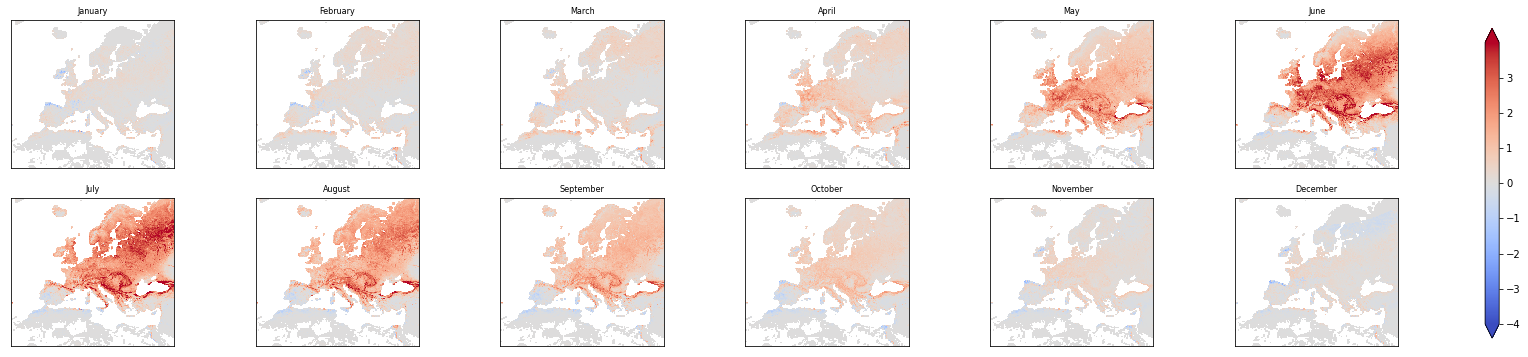

In [10]:
# Plotting the mean monthly differences between SPOT and MODIS
import calendar
fig, axes = plt.subplots(2,6,sharex=True,figsize=(32,6))
k=0
for i in range(2):
    for j in range(6):        
        plot=diff[k,:,:].plot(ax=axes[i,j], cmap='coolwarm', vmin=-4, vmax=4)
        axes[i,j].set_xticks([]),axes[i,j].set_yticks([])
        axes[i,j].set(xlabel=None), axes[i,j].set(ylabel=None)
        axes[i,j].set(title=calendar.month_name[k+1])
        axes[i,j].title.set_size(8)
        plot.colorbar.remove() 
        k=k+1

cbar = fig.colorbar(plot, ax=axes.ravel().tolist(), shrink=0.95,extend='both')
cbar.set_ticks(np.arange(-4, 4, 1))
plt.show()

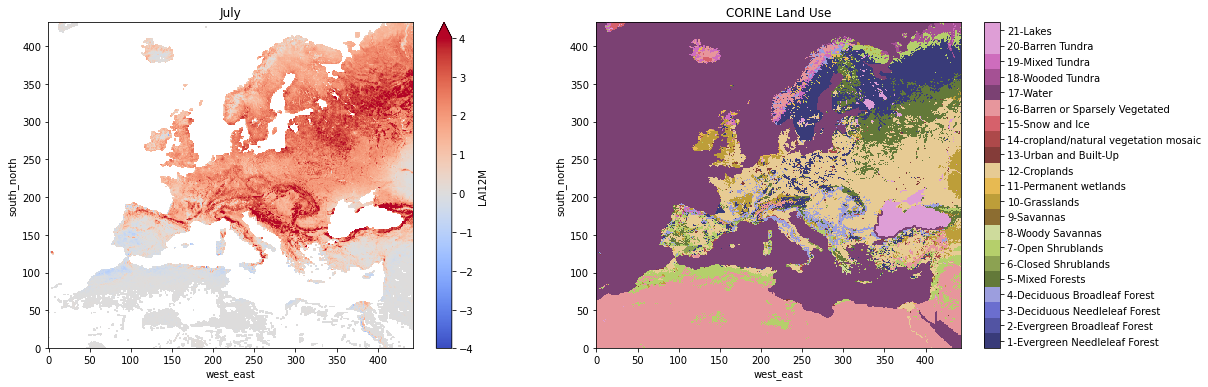

In [11]:
# Including LU INDEX map 
ds_spot = xr.open_dataset(f'{file_lai_updated}')
lu_index = ds_spot['LU_INDEX'][:]
month=6  # plot lai for month July, note that id for January is 0

fig, axes = plt.subplots(ncols=2,sharex=True,figsize=(18,6))

#plot differences
plot=diff[month,:,:].plot(ax=axes[0], cmap='coolwarm', vmin=-4, vmax=4) 
axes[0].set(title=calendar.month_name[month+1])

#plot lan se index
cmap = mpl.cm.tab20b
bounds = np.linspace(1,21,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plot=lu_index[0,:,:].plot(ax=axes[1],cmap=cmap)
plot.colorbar.remove()                         
axes[1].set(title="CORINE Land Use")

# List of all land use categories categories 
LU_categories=['1-Evergreen Needleleaf Forest','2-Evergreen Broadleaf Forest','3-Deciduous Needleleaf Forest','4-Deciduous Broadleaf Forest',                        
'5-Mixed Forests','6-Closed Shrublands','7-Open Shrublands','8-Woody Savannas','9-Savannas','10-Grasslands','11-Permanent wetlands' ,                               
'12-Croplands', '13-Urban and Built-Up','14-cropland/natural vegetation mosaic','15-Snow and Ice','16-Barren or Sparsely Vegetated',                      
'17-Water','18-Wooded Tundra','19-Mixed Tundra','20-Barren Tundra', '21-Lakes' ]

# Adding the colorbar for the land use map
cbar=plt.colorbar(plot, ticks=np.linspace(1,21,21), boundaries=np.arange(0.5,22,1))
cbar.ax.set_yticklabels(LU_categories)
plt.show()

# Land use problem: Black Sea to Lake

In [12]:
# Resolving problems with lakes
ds_corine = xr.open_dataset(f'{file_lai_updated}')      
ds_modis = xr.open_dataset(f'{file_modis_lakes}')

## LU_INDEX variable

In Corine dataset that covers only Europe sees the Black Sea as sea and not a lake. The missing part of the domain is filled with the modis data, and the rest of the Black sea has is seen as lake. So the script bellow redifines inland lakes that are seen as sea in Corine to the lakes.  

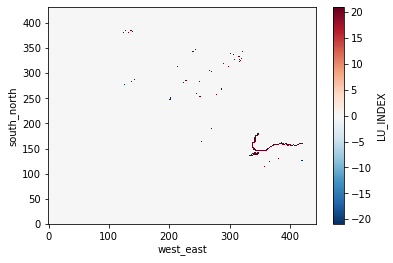

In [13]:
# Plotting difference between CORINE and MODIS for lakes (sea = 17, lakes = 21)
ds_corine['LU_INDEX'].data[ds_corine['LU_INDEX'].data!=21.] = 0.
ds_modis['LU_INDEX'].data[ds_modis['LU_INDEX'].data!=21.] = 0.
diff = ds_modis['LU_INDEX'][:]-ds_corine['LU_INDEX'][:]
diff[0,:,:].plot()

In [14]:
ds_corine = xr.open_dataset(f'{file_lai_updated}')      
ds_modis = xr.open_dataset(f'{file_modis_lakes}') 
lu_corine = ds_corine['LU_INDEX'][:]
lu_modis = ds_modis['LU_INDEX'][:]

# Define Black Sea mask
blacksea_mask = (ds_corine['XLONG_M'].data>25)*(ds_corine['XLONG_M'].data<42)*\
                (ds_corine['XLAT_M'].data>40)*(ds_corine['XLAT_M'].data<47.4)

# Define condition to redefine category
cond = (ds_modis['LU_INDEX'].data==21. ) * \
       (ds_corine['LU_INDEX'].data==17.) * \
       (ds_corine['LANDMASK'].data==0. ) * blacksea_mask

ds_corine['LU_INDEX'].data[cond] = 21.

In [15]:
# Redefinding lakes in variable LANDUSEF
ds_corine_default = xr.open_dataset(f'{file_lai_updated}')      

blacksea_mask = (ds_corine['XLONG_M'].data>25)*(ds_corine['XLONG_M'].data<45)*\
                (ds_corine['XLAT_M'].data>38)*(ds_corine['XLAT_M'].data<48)

# Define additional conditions to redefine LANDUSEF, for the area over land
cond1 = (ds_corine['LANDUSEF'].data[:,16,:,:]!=0.)*blacksea_mask
cond2 = (ds_modis ['LANDUSEF'].data[:,20,:,:]!=0.)*(ds_corine['LANDMASK'].data==1.)*blacksea_mask

ds_corine['LANDUSEF'].data[:,16,:,:][cond]= ds_modis['LANDUSEF'].data[:,16,:,:][cond]
ds_corine['LANDUSEF'].data[:,16,:,:][cond1]= ds_modis['LANDUSEF'].data[:,16,:,:][cond1]
ds_corine['LANDUSEF'].data[:,20,:,:][cond]= ds_modis['LANDUSEF'].data[:,20,:,:][cond]
ds_corine['LANDUSEF'].data[:,20,:,:][cond2]= ds_modis['LANDUSEF'].data[:,20,:,:][cond2]

[Text(0.5, 1.0, 'LANDUSEF diff over lake')]

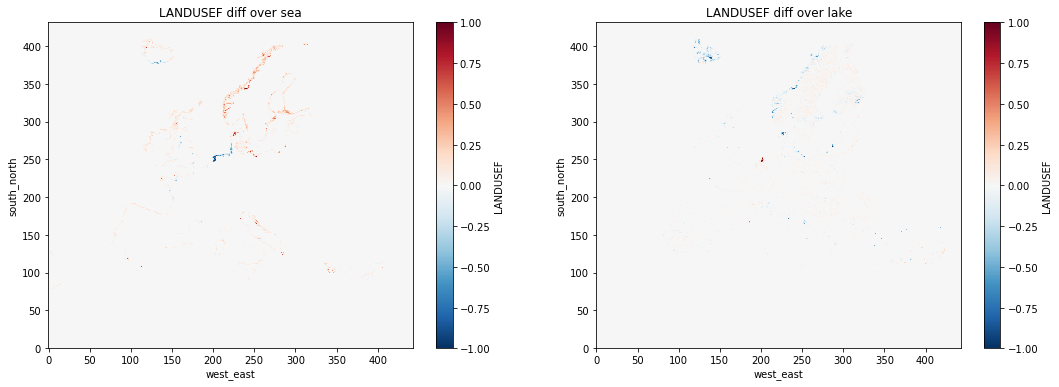

In [16]:
# Checking LANDUSEF for sea category
LUF_corine=ds_corine['LANDUSEF'][:]
LUF_modis=ds_modis['LANDUSEF'][:]
diff = LUF_corine - LUF_modis

# plot diff for sea category (17):
fig, axes = plt.subplots(ncols=2,sharex=True,figsize=(18,6))
plot=diff[0,16,:,:].plot(ax=axes[0]) 
axes[0].set(title="LANDUSEF diff over sea")
plot=diff[0,20,:,:].plot(ax=axes[1]) 
axes[1].set(title="LANDUSEF diff over lake")

In [18]:
# Saving the file
if os.path.exists(f'{file_final2lake}'):
    os.remove(f'{file_final2lake}')
ds_corine.to_netcdf(f'{file_final2lake}')

# Land use problem: Black Sea to sea

In [20]:
# Resolving problems with lakes
ds_corine = xr.open_dataset(f'{file_final2lake}')      
ds_modis = xr.open_dataset(f'{file_modis}')

# Define black sea mask
blacksea_mask = (ds_corine['XLONG_M'].data>25)*(ds_corine['XLONG_M'].data<42)*\
                (ds_corine['XLAT_M'].data>40)*(ds_corine['XLAT_M'].data<47.4)

In [21]:
# Define condition to mask the black sea
cond = (ds_modis['LU_INDEX'].data==17.) * \
       (ds_corine['LU_INDEX'].data==21.) * \
       (ds_corine['LANDMASK'].data==0. ) * blacksea_mask
        
ds_corine['LU_INDEX'].data[cond] = 17.

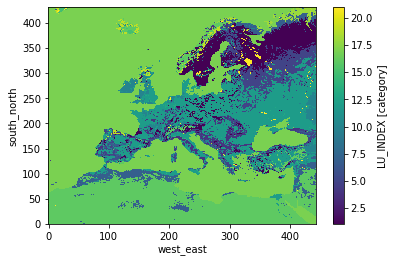

In [22]:
ds_corine['LU_INDEX'][0,:,:].plot()

In [27]:
# Redefinding lakes in variable LANDUSEF
ds_corine_lake = xr.open_dataset(f'{file_final2lake}') 
ds_modis_lake = xr.open_dataset(f'{file_modis_lakes}') 

# Define additional conditions:
cond  = (ds_modis['LU_INDEX'].data==17.)*(ds_corine_lake['LU_INDEX'].data==21.)*(ds_corine_lake['LANDMASK'].data==0. )*blacksea_mask
cond1 = (ds_corine['LANDUSEF'].data[:,16,:,:]!=0.)*blacksea_mask
cond2 = (ds_modis['LANDUSEF'].data[:,16,:,:]!=1.)*(ds_corine['LANDMASK'].data==1.)*blacksea_mask

# Mask the Black sea:
ds_corine['LANDUSEF'].data[:,16,:,:][cond] = ds_modis['LANDUSEF'].data[:,16,:,:][cond]
ds_corine['LANDUSEF'].data[:,16,:,:][cond1]= ds_modis['LANDUSEF'].data[:,16,:,:][cond1]
ds_corine['LANDUSEF'].data[:,20,:,:][cond] =  0.
ds_corine['LANDUSEF'].data[:,20,:,:][cond2]= 0. 

[Text(0.5, 1.0, 'corine LANDUSEF over lake')]

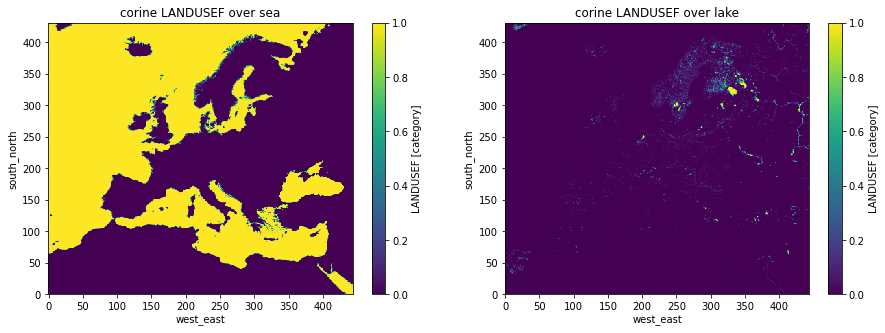

In [28]:
# plot LANDUSEF for corine:
fig, axes = plt.subplots(ncols=2,sharex=True,figsize=(15,5))
plot=ds_corine['LANDUSEF'][0,16,:,:].plot(ax=axes[0]) 
axes[0].set(title="corine LANDUSEF over sea")
plot=ds_corine['LANDUSEF'][0,20,:,:].plot(ax=axes[1]) 
axes[1].set(title="corine LANDUSEF over lake")

[Text(0.5, 1.0, 'modis lakes LANDUSEF over lake')]

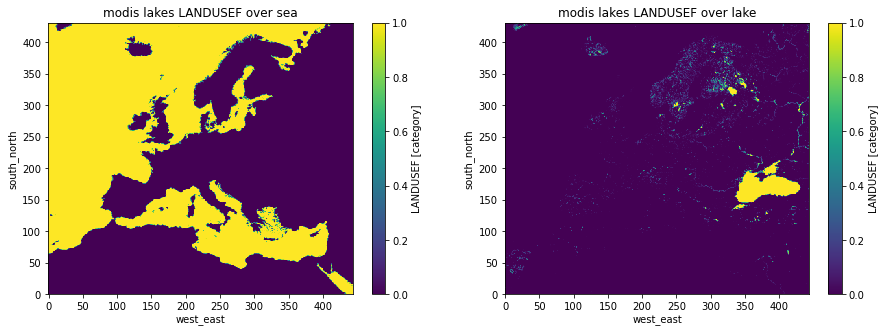

In [29]:
# plot LANDUSEF for modis:
fig, axes = plt.subplots(ncols=2,sharex=True,figsize=(15,5))
plot=ds_modis_lake['LANDUSEF'][0,16,:,:].plot(ax=axes[0]) 
axes[0].set(title="modis lakes LANDUSEF over sea")
plot=ds_modis_lake['LANDUSEF'][0,20,:,:].plot(ax=axes[1]) 
axes[1].set(title="modis lakes LANDUSEF over lake")

In [30]:
# Saving the file
if os.path.exists(f'{file_final2sea}'):
    os.remove(f'{file_final2sea}')
ds_corine.to_netcdf(f'{file_final2sea}')